## 13. 3.7 Self-consistent schrodnger poisson equation

## Simulation flow
* Self-consistency
  - The electron density is not consistent with the Poisson equation.
  - Better way?
    1) Non-linear Poisson equation(Semi-classical), $\phi(z)$   
    2) Schrodinger equation, $\psi_{z,n}(z)$ and $E_{z,n}$   
    3) Calculation of the electron density, $n(z)$   
    4) Poisson equation, $\phi(z)$ -> feedback to 2)

### Problem
* Repeat L12
* However, in this time, you must get the self-consistent solution.
* Check the covergence behavior.
* Compare the electron densities(the non-self-consistent and self-consistent ones) in the z azis.
  

## self-consistent schrodinger poisson
$$-\frac{\hbar^2}{2m_{zz}}\frac{\partial^2}{\partial^2 z}\psi(z) + V(z)\psi(z)=E_{z,n}\psi(z)\quad (n=1,2,3...) $$
$$V(z)=-q\phi(z)+(E_C-E_i) $$
$$\sum_{i=interface1+1}^{interface2-1}|\psi_{z,n,i}|^2\Delta Z=1 $$
$$n(z)(cm^{-3})=\frac{1}{L_zL_y}\sum_{n=1}^\infty|\psi_{z,n,i}|^2\frac{L_zL_y}{(2\pi)^2}(2\pi)\frac{m_d}{\hbar^2}k_B T ln(1+exp\left(\frac{-E_{z,n}+E_F}{k_B T} \right)) $$
$$n_{total}(z)= 2 \times 2 \times \sum_{valley=1}^3 n(z) $$
위와 같은 schrodinger solver를 구성하고, 풀면 전자 농도가 나오게 되는데, 이 때 나오는 전자 농도를 Poisson solver에 다시 넣게 된다. Poisson solver를 풀게 되면 schrodinger solver의 결과에 따라서 potential이 update가 되고, 이를 다시 schrodinger solver를 푸는데, 사용하는 loop를 형성하게 된다. 이 결과가 어느 정도의 수렴도를 가질 때까지 반복을 한다.   
하지만, 전자 농도를 넣을 때, 다음과 같은 2가지 방식을 시도한다.
$$1. n_{new}=n_{sch}(z) $$
$$2. n_{new,0}=n_{sch}\times e^{\frac{\delta\phi}{V_T}}$$
$$n_{new,n}=n_{new,n-1}\times e^{\frac{\delta\phi}{V_T}}(when\ repeated\ for\ n\ times) $$
1번 방식은 schrodinger solver를 풀어서 나온 전자 농도를 상수로서 poisson solver를 넣는 것이다. 2번 방식은 schrodinger solver를 풀어서 나온 전자 농도를 poisson solver를 풀 때 계속 변하는 값으로 넣게 된다. 이 때 변하는 정도는 위와 같은 수식으로 나타나게 된다.


--- Solving for Vg = 0.00 V (index 0) ---
Initial Poisson solve...

--- Solving for Vg = 0.10 V (index 1) ---
Initial Poisson solve...

--- Solving for Vg = 0.20 V (index 2) ---
Initial Poisson solve...

--- Solving for Vg = 0.30 V (index 3) ---
Initial Poisson solve...

--- Solving for Vg = 0.40 V (index 4) ---
Initial Poisson solve...

--- Solving for Vg = 0.50 V (index 5) ---
Initial Poisson solve...

--- Solving for Vg = 0.60 V (index 6) ---
Initial Poisson solve...

--- Solving for Vg = 0.70 V (index 7) ---
Initial Poisson solve...

--- Solving for Vg = 0.80 V (index 8) ---
Initial Poisson solve...

--- Solving for Vg = 0.90 V (index 9) ---
Initial Poisson solve...

--- Solving for Vg = 1.00 V (index 10) ---
Initial Poisson solve...
Simulation complete.


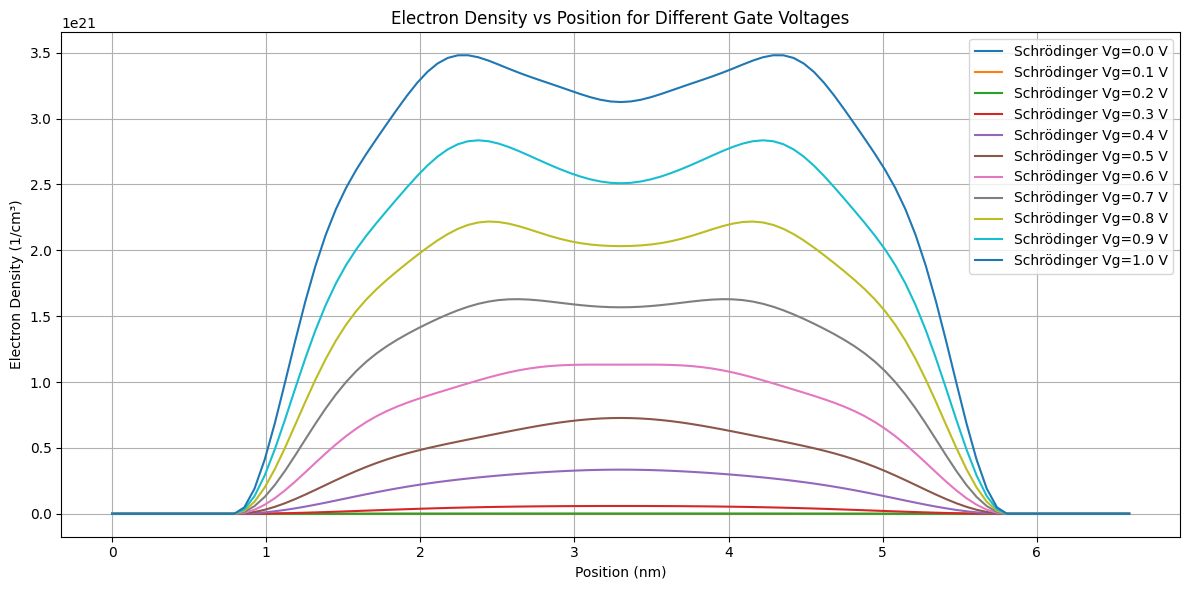

In [33]:
import numpy as np
from scipy.constants import e, m_e, h, k, epsilon_0, pi
from scipy.sparse import lil_matrix
from scipy.linalg import eigh
import matplotlib.pyplot as plt

# Constants
q = e
m0 = m_e
hbar = h / (2 * pi)
T = 300
e_si = 11.7
e_ox = 3.9
nint = 1.075e16  # 1/m^3
thermal = k * T / q
e0 = epsilon_0

# Device parameters
width = 5e-9
tox = 0.8e-9
N = 101
dz = (width + 2 * tox) / (N - 1)
interface1 = round(tox / dz)
interface2 = round((tox + width) / dz)
N1 = interface2 - interface1 - 1
Na = 1e24
Lx = 100e-9
Ly = 100e-9
nmax = N1
coeff = dz**2 * q / e0

# Gate voltages
Vg_list = np.linspace(0, 1.0, 11)
Electron = np.zeros((N, len(Vg_list)))
Nz = np.zeros((N, len(Vg_list)))

# Initial potential
phi_init = 0.33374

# ---------- Function: Poisson Solver ----------
def solve_poisson(phi, Vg, update_density=None):
    for _ in range(40):
        Jaco = lil_matrix((N, N))
        res = np.zeros(N)

        for ii in range(N):
            if ii == 0 or ii == N - 1:
                res[ii] = phi[ii] - phi_init - Vg
                Jaco[ii, ii] = 1
            elif interface1 < ii < interface2:
                n_term = nint * np.exp(phi[ii] / thermal)
                if update_density is not None:
                    n_term = update_density[ii]
                res[ii] = e_si * (phi[ii-1] - 2 * phi[ii] + phi[ii+1]) + coeff * (-Na - n_term)
                Jaco[ii, ii+1] = e_si
                Jaco[ii, ii] = -2 * e_si - coeff * n_term / thermal
                Jaco[ii, ii-1] = e_si
            elif ii < interface1 or ii > interface2:
                res[ii] = e_ox * (phi[ii-1] - 2 * phi[ii] + phi[ii+1])
                Jaco[ii, ii+1] = e_ox
                Jaco[ii, ii] = -2 * e_ox
                Jaco[ii, ii-1] = e_ox
            elif ii == interface1 or ii == interface2:
                left_eps = e_ox if ii == interface1 else e_si
                right_eps = e_si if ii == interface1 else e_ox
                res[ii] = right_eps * (-phi[ii] + phi[ii+1]) - left_eps * (phi[ii] - phi[ii-1])
                n_term = nint * np.exp(phi[ii] / thermal)
                if update_density is not None:
                    n_term = update_density[ii]
                res[ii] += coeff * (-Na - n_term) / 2
                Jaco[ii, ii+1] = right_eps
                Jaco[ii, ii] = -right_eps - left_eps - coeff * n_term / (2 * thermal)
                Jaco[ii, ii-1] = left_eps

        delta_phi = np.linalg.solve(Jaco.toarray(), -res)
        phi += delta_phi

        if np.max(np.abs(delta_phi)) < 1e-15:
            break
    return phi


# ---------- Function: Schrödinger-Poisson Solver ----------
def solve_schrodinger(phi):
    V = -q * phi + 0.56 * q
    V_sch = V[interface1+1:interface2]

    Elec_valley = np.zeros((N1, 3))
    for valley in range(3):
        if valley == 0:
            mzz, mxx, myy = 0.91 * m0, 0.19 * m0, 0.19 * m0
        elif valley == 1:
            mzz, mxx, myy = 0.19 * m0, 0.91 * m0, 0.19 * m0
        else:
            mzz, mxx, myy = 0.19 * m0, 0.19 * m0, 0.91 * m0
        md = np.sqrt(mxx * myy)

        main_diag = -2 - 2 * mzz * dz**2 * V_sch / hbar**2
        ham = np.diag(main_diag.copy())
        ham += np.diag(np.ones(N1 - 1), 1)
        ham += np.diag(np.ones(N1 - 1), -1)

        eigvals, eigvecs = eigh(ham)
        Ezn = eigvals / (-2 * mzz * dz**2) * hbar**2

        normalize = np.zeros_like(eigvecs)
        for n in range(nmax):
            prob = eigvecs[:, n]**2
            normalize[:, n] = prob / (np.sum(prob) * dz)

        for z in range(N1):
            for n in range(nmax):
                Ez = Ezn[n]
                fermi_term = (Lx * Ly / (2 * pi)) * (md / hbar**2) * k * T * np.log(1 + np.exp(-Ez / (k * T)))
                Elec_valley[z, valley] += normalize[z, n] * fermi_term / (Lx * Ly)

    Nz_temp = 4 * np.sum(Elec_valley, axis=1)
    Nz_full = np.zeros(N)
    Nz_full[interface1+1:interface2] = Nz_temp
    return Nz_full


# ---------- Main Loop ----------
for idx, Vg in enumerate(Vg_list):
    print(f"\n--- Solving for Vg = {Vg:.2f} V (index {idx}) ---")
    phi = np.full(N, phi_init)
    print("Initial Poisson solve...")
    phi = solve_poisson(phi, Vg)
    Electron[:, idx] = nint * np.exp(phi / thermal) / 1e6

    for _ in range(50):  # Self-consistent loop
        #print("  Solving Schrödinger equation...")
        Nz_new = solve_schrodinger(phi)
        Nz[:, idx] = Nz_new / 1e6
        #print("  Updating Poisson with Schrödinger charge...")
        phi = solve_poisson(phi, Vg, update_density=Nz_new)

        if np.max(Nz_new) < 1e-3:  # Convergence (can be tuned)
            print("  Converged.")
            break

print("Simulation complete.")

# ---------- Plotting ----------
z = np.linspace(0, (width + 2 * tox) * 1e9, N)  # nm
selected_indices = [0, 1, 2, 3, 4,5,6,7,8,9,10]

plt.figure(figsize=(12, 6))
for i in selected_indices:
    #plt.plot(z, Electron[:, i], label=f'Poisson Vg={i*0.1:.1f} V', linestyle='--')
    plt.plot(z, Nz[:, i], label=f'Schrödinger Vg={i*0.1:.1f} V')

plt.xlabel('Position (nm)')
plt.ylabel('Electron Density (1/cm³)')
plt.title('Electron Density vs Position for Different Gate Voltages')
#plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



[INFO] Solving for Vg = 0.00 V (index 0)
    Poisson solved.

[INFO] Solving for Vg = 0.10 V (index 1)
    Poisson solved.

[INFO] Solving for Vg = 0.20 V (index 2)
    Poisson solved.

[INFO] Solving for Vg = 0.30 V (index 3)
    Poisson solved.

[INFO] Solving for Vg = 0.40 V (index 4)
    Poisson solved.

[INFO] Solving for Vg = 0.50 V (index 5)
    Poisson solved.

[INFO] Solving for Vg = 0.60 V (index 6)
    Poisson solved.

[INFO] Solving for Vg = 0.70 V (index 7)
    Poisson solved.

[INFO] Solving for Vg = 0.80 V (index 8)
    Poisson solved.

[INFO] Solving for Vg = 0.90 V (index 9)
    Poisson solved.

[INFO] Solving for Vg = 1.00 V (index 10)
    Poisson solved.

[INFO] Self-consistent loop for Vg = 0.00 V

[INFO] Self-consistent loop for Vg = 0.10 V

[INFO] Self-consistent loop for Vg = 0.20 V

[INFO] Self-consistent loop for Vg = 0.30 V

[INFO] Self-consistent loop for Vg = 0.40 V

[INFO] Self-consistent loop for Vg = 0.50 V

[INFO] Self-consistent loop for Vg = 0.60 V

[

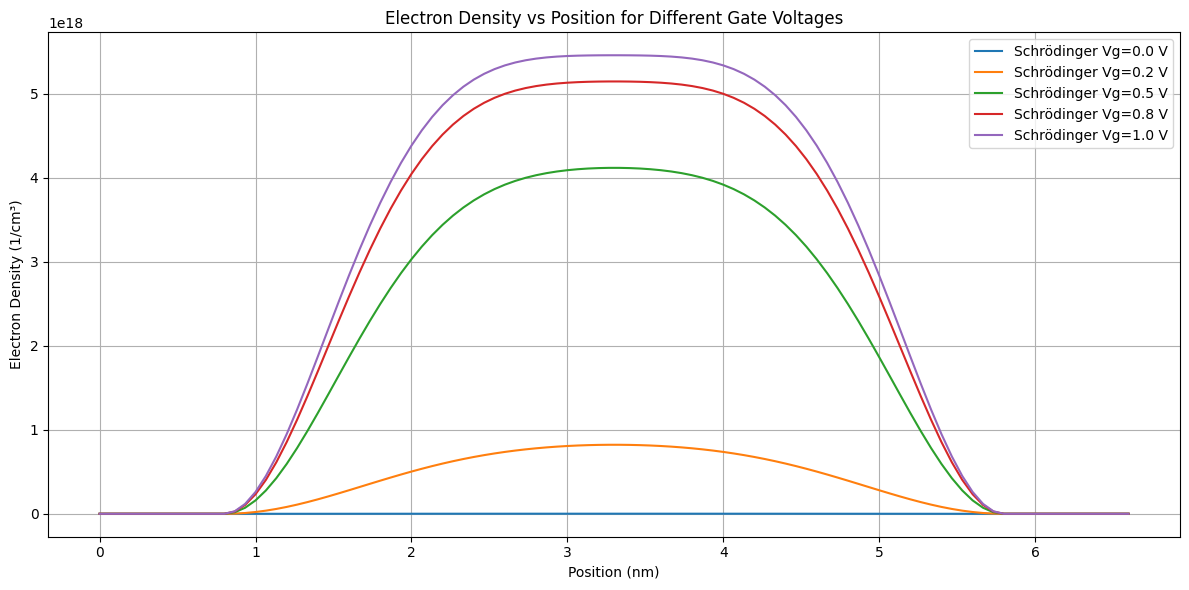

In [32]:
import numpy as np
from scipy.constants import e, m_e, h, k, epsilon_0, pi
from scipy.sparse import lil_matrix
from scipy.linalg import eigh

# Constants
q = e
m0 = m_e
hbar = h / (2 * pi)
T = 300
e_si = 11.7
e_ox = 3.9
nint = 1.075e16  # 1/m^3
thermal = k * T / q
e0 = epsilon_0

# Device parameters
width = 5e-9
tox = 0.8e-9
N = 100
dz = (width + 2 * tox) / (N - 1)
interface1 = round(tox / dz)
interface2 = round((tox + width) / dz)
N1 = interface2 - interface1 - 1
Na = 1e24
Lx = 100e-9
Ly = 100e-9
nmax = N1

coeff = dz * dz * q / e0

Electron = np.zeros((N, 11))
Nz = np.zeros((N, 11))

###################################
#### For simple poisson solver ####
###################################

phi = np.full(N, 0.33374)

for index_Vg in range(11):
    Vg = index_Vg * 0.1
    print(f"\n[INFO] Solving for Vg = {Vg:.2f} V (index {index_Vg})")
    for _ in range(40):
        Jaco = lil_matrix((N, N))
        res = np.zeros(N)

        for ii in range(N):
            if ii == 0 or ii == N - 1:
                res[ii] = phi[ii] - 0.33374 - Vg
                Jaco[ii, ii] = 1
            elif interface1 < ii < interface2:
                res[ii] = e_si * (phi[ii-1] - 2 * phi[ii] + phi[ii+1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal))
                Jaco[ii, ii+1] = e_si
                Jaco[ii, ii] = -2 * e_si - coeff * nint * np.exp(phi[ii] / thermal) / thermal
                Jaco[ii, ii-1] = e_si
            elif ii < interface1 or ii > interface2:
                res[ii] = e_ox * (phi[ii-1] - 2 * phi[ii] + phi[ii+1])
                Jaco[ii, ii+1] = e_ox
                Jaco[ii, ii] = -2 * e_ox
                Jaco[ii, ii-1] = e_ox
            elif ii == interface1:
                res[ii] = e_si * (-phi[ii] + phi[ii+1]) - e_ox * (phi[ii] - phi[ii-1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal)) / 2
                Jaco[ii, ii+1] = e_si
                Jaco[ii, ii] = -e_si - e_ox - coeff * nint * np.exp(phi[ii] / thermal) / (2 * thermal)
                Jaco[ii, ii-1] = e_ox
            elif ii == interface2:
                res[ii] = e_ox * (-phi[ii] + phi[ii+1]) - e_si * (phi[ii] - phi[ii-1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal)) / 2
                Jaco[ii, ii+1] = e_ox
                Jaco[ii, ii] = -e_si - e_ox - coeff * nint * np.exp(phi[ii] / thermal) / (2 * thermal)
                Jaco[ii, ii-1] = e_si

        delphi = np.linalg.solve(Jaco.toarray(), -res)
        phi += delphi

        if np.max(np.abs(delphi)) < 1e-15:
            break

    Elec_save = nint * np.exp(phi / thermal) / 1e6
    Electron[interface1:interface2, index_Vg] = Elec_save[interface1:interface2]
    eDensity_Poisson = Electron / 1e6
    print("    Poisson solved.")
########################################################
#### For self-consistent poisson-schrodinger solver ####
########################################################

#### initial guess ####
phi = np.full(N, 0.33374)

for index_Vg in range(11):
    Vg = index_Vg * 0.1
    #print(f"\n[INFO] Self-consistent loop for Vg = {Vg:.2f} V")
    for _ in range(40):
        Jaco = lil_matrix((N, N))
        res = np.zeros(N)

        for ii in range(N):
            if ii == 0 or ii == N - 1:
                res[ii] = phi[ii] - 0.33374
                Jaco[ii, ii] = 1
            elif interface1 < ii < interface2:
                res[ii] = e_si * (phi[ii-1] - 2 * phi[ii] + phi[ii+1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal))
                Jaco[ii, ii+1] = e_si
                Jaco[ii, ii] = -2 * e_si - coeff * nint * np.exp(phi[ii] / thermal) / thermal
                Jaco[ii, ii-1] = e_si
            elif ii < interface1 or ii > interface2:
                res[ii] = e_ox * (phi[ii-1] - 2 * phi[ii] + phi[ii+1])
                Jaco[ii, ii+1] = e_ox
                Jaco[ii, ii] = -2 * e_ox
                Jaco[ii, ii-1] = e_ox
            elif ii == interface1:
                res[ii] = e_si * (-phi[ii] + phi[ii+1]) - e_ox * (phi[ii] - phi[ii-1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal)) / 2
                Jaco[ii, ii+1] = e_si
                Jaco[ii, ii] = -e_si - e_ox - coeff * nint * np.exp(phi[ii] / thermal) / (2 * thermal)
                Jaco[ii, ii-1] = e_ox
            elif ii == interface2:
                res[ii] = e_ox * (-phi[ii] + phi[ii+1]) - e_si * (phi[ii] - phi[ii-1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal)) / 2
                Jaco[ii, ii+1] = e_ox
                Jaco[ii, ii] = -e_si - e_ox - coeff * nint * np.exp(phi[ii] / thermal) / (2 * thermal)
                Jaco[ii, ii-1] = e_si

        delphi = np.linalg.solve(Jaco.toarray(), -res)
        phi += delphi

        if np.max(np.abs(delphi)) < 1e-15:
            break

#######################################
for index_Vg in range(11):
    Vg = index_Vg * 0.1
    print(f"\n[INFO] Self-consistent loop for Vg = {Vg:.2f} V")
    for schrodinger in range(50):
        #print(f"    Schrödinger iteration {schrodinger}")
        Elec_valley = np.zeros((N1, 3))
        ham = np.zeros((N1, N1))

        V = -q * phi + 0.56 * q

        for valley_type in range(3):
            if valley_type == 0:
                mzz = 0.91 * m0
                mxx = 0.19 * m0
                myy = 0.19 * m0
                md = np.sqrt(mxx * myy)
            elif valley_type == 1:
                mzz = 0.19 * m0
                mxx = 0.91 * m0
                myy = 0.19 * m0
                md = np.sqrt(mxx * myy)
            else:
                mzz = 0.19 * m0
                mxx = 0.19 * m0
                myy = 0.91 * m0
                md = np.sqrt(mxx * myy)

            for a in range(N1):
                V_local = V[interface1 + 1 + a]
                ham[a, a] = -2 - 2 * mzz * dz * dz * V_local / hbar**2
                if a > 0:
                    ham[a, a - 1] = 1
                if a < N1 - 1:
                    ham[a, a + 1] = 1

            eigvals, eigvecs = eigh(ham)

            # Ezn and normalize use original eigvals and eigvecs order (no sorting)
            Ezn = eigvals / (-2 * mzz * dz * dz) * hbar**2
            normalize = np.zeros_like(eigvecs)
            for n in range(N1):
                dist = eigvecs[:, n] ** 2
                normalize[:, n] = dist / (np.sum(dist) * dz)

            for z in range(N1):
                for n in range(nmax):
                    Ez = Ezn[n]
                    sub = Lx * Ly / (2 * pi) * md / hbar**2 * k * T * np.log(1 + np.exp(-Ez / (k * T)))
                    Elec_valley[z, valley_type] += normalize[z, n] * sub / (Lx * Ly)

        Nz[interface1 + 1:interface2, index_Vg] = 4 * np.sum(Elec_valley, axis=1) / 1e6

        for _ in range(30):
            Jaco = lil_matrix((N, N))
            res = np.zeros(N)

            for ii in range(N):
                if ii == 0 or ii == N - 1:
                    res[ii] = phi[ii] - 0.33374 - Vg
                    Jaco[ii, ii] = 1
                elif interface1 < ii < interface2:
                    res[ii] = e_si * (phi[ii - 1] - 2 * phi[ii] + phi[ii + 1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal))
                    Jaco[ii, ii + 1] = e_si
                    Jaco[ii, ii] = -2 * e_si - coeff * nint * np.exp(phi[ii] / thermal) / thermal
                    Jaco[ii, ii - 1] = e_si
                elif ii < interface1 or ii > interface2:
                    res[ii] = e_ox * (phi[ii - 1] - 2 * phi[ii] + phi[ii + 1])
                    Jaco[ii, ii + 1] = e_ox
                    Jaco[ii, ii] = -2 * e_ox
                    Jaco[ii, ii - 1] = e_ox
                elif ii == interface1:
                    res[ii] = e_si * (-phi[ii] + phi[ii + 1]) - e_ox * (phi[ii] - phi[ii - 1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal)) / 2
                    Jaco[ii, ii + 1] = e_si
                    Jaco[ii, ii] = -e_si - e_ox - coeff * nint * np.exp(phi[ii] / thermal) / (2 * thermal)
                    Jaco[ii, ii - 1] = e_ox
                elif ii == interface2:
                    res[ii] = e_ox * (-phi[ii] + phi[ii + 1]) - e_si * (phi[ii] - phi[ii - 1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal)) / 2
                    Jaco[ii, ii + 1] = e_ox
                    Jaco[ii, ii] = -e_si - e_ox - coeff * nint * np.exp(phi[ii] / thermal) / (2 * thermal)
                    Jaco[ii, ii - 1] = e_si

            update_phi2 = np.linalg.solve(Jaco.toarray(), -res)
            phi += update_phi2
            Nz[:, index_Vg] *= np.exp(update_phi2 / thermal)

            if np.max(np.abs(update_phi2)) < 1e-15:
                #print("    Converged.")
                break

    eDensity_Schrodinger = Nz / 1e6
print("\n[INFO] Simulation complete. Plotting results...")

# Position grid in nanometers
z = np.linspace(0, (width + 2 * tox) * 1e9, N)  # Convert to nm

# Plot for selected gate voltages
selected_indices = [0, 2, 5, 8, 10]  # Corresponds to Vg = 0.0, 0.2, 0.5, 0.8, 1.0

plt.figure(figsize=(12, 6))
for i in selected_indices:
    #plt.plot(z, Electron[:, i], label=f'Poisson Vg={i*0.1:.1f} V', linestyle='--')
    plt.plot(z, Nz[:, i], label=f'Schrödinger Vg={i*0.1:.1f} V')

plt.xlabel('Position (nm)')
plt.ylabel('Electron Density (1/cm³)')
plt.title('Electron Density vs Position for Different Gate Voltages')
#plt.yscale('log')  # Electron density varies exponentially
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_10380\2692413049.py:122: RuntimeWarning: overflow encountered in exp
  density = 2*np.sum((psi**2)/((1+np.exp(E/kT))*Lx*Ly),axis=1)


2.9266357115531605e-09
2.118221648084173e-08
5.72969724998984e-07
9.629124461119076e-07
9.335486625960954e-07
9.910847460492533e-07
9.925788213571707e-07
9.5737791050432e-07
9.815973058824312e-07
9.963881484331694e-07
9.655767356786527e-07
[  2.   3.   6.  38.  78. 110. 149. 158. 172. 217. 232.]


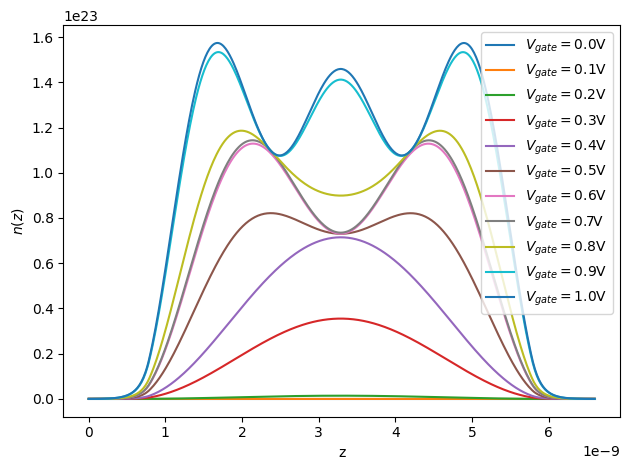

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sc
import scipy.linalg as slin
import scipy.integrate as inte
import fractions

#np.set_printoptions(formatter={'all':lambda x: str(fractions.Fraction(x).limit_denominator())})

Nc = 2.86*1e+25
#kT = 25.85*1e-3
kT = sc.k*300
ni = Nc*np.exp(-0.56*sc.e/kT)
N = 500
Nacc = 1e+24
q = sc.e 
e1 = 3.9*sc.epsilon_0
e2 = 11.7*sc.epsilon_0
deltax = ((6.6*1e-9)/(N-1))
Lx = 1e-7
Ly = 1e-7
mzz = 0.19*sc.m_e

inter2 = int((N-1)*(5.8/6.6))
inter1 = int((N-1)*(0.8/6.6))
thermal = kT/q

itr = 20 
centerphi = np.zeros(itr)
def density_phi_cl(gate):
    p_density=np.zeros(N)
    e_density=np.zeros(N)
    density=np.zeros(N)
    phi = np.full(N,0.33374)
    #for i in range(itr) :
    GV = (gate)/10.0
    centerphi = 1000
    diff = 1000
    while diff>1e-5 :
        centerphi = phi[int(N/2)]
        e_density = ni*np.exp(q*phi/kT)
        e_density[:inter1] = 0
        e_density[inter2+1:] = 0

        #p_density = ni*np.exp(-q*phi/kT)
        #p_density[:inter1] = 0
        #p_density[inter2+1:] = 0
 
        density = 2*ni*np.sinh(q*phi/kT)
        density[:inter1] = 0
        density[inter2+1:] = 0

        H = np.zeros((N,N))
        np.fill_diagonal(H,-2*e1)
        np.fill_diagonal(H[1:],e1)
        np.fill_diagonal(H[:,1:],e1)

        np.fill_diagonal(H[0:inter2+1],-2*e2)
        np.fill_diagonal(H[1:inter2+1],e2)
        np.fill_diagonal(H[:,1:inter2+1],e2)
        H[inter2][inter2] = (-e2-e1)

        np.fill_diagonal(H[0:inter1+1],-2*e1)
        np.fill_diagonal(H[1:inter1+1],e1)
        np.fill_diagonal(H[:,1:inter1+1],e1)
        H[inter1][inter1] = (-e2-e1)

        H[0][0] = 1
        H[0][1] = 0
        H[N-1][N-1] = 1
        H[N-1][N-2] = 0

        B = np.zeros(N)
        B[inter1] = q*(Nacc+density[inter1])/2.0
        B[inter1+1:inter2] = q*(Nacc+density[inter1+1:inter2])
        B[inter2] = q*(Nacc+density[inter2])/2.0
        B = B*deltax*deltax
        B[0] = 0.33374 + GV
        B[N-1] = 0.33374 + GV

        res = np.zeros(N)
        res = np.matmul(H,phi) - B

        der_B = np.zeros((N,N))
        np.fill_diagonal(der_B[inter1:inter2,inter1:inter2],2*q*(q/kT)*ni*np.cosh(q*phi[inter1:inter2]/kT))
        der_B[inter1,inter1] = (q/kT)*q*ni*np.cosh(q*phi[inter1]/kT)
        der_B[inter2,inter2] = (q/kT)*q*ni*np.cosh(q*phi[inter2]/kT)

        der_B = der_B*deltax*deltax

        Jaco = np.zeros((N,N))
        Jaco = H - der_B
        
        phi=phi + slin.solve(Jaco,-res)

        diff = abs(phi[int(N/2)]-centerphi)
        
    x = np.linspace(0,6.6*1e-9,num=N,endpoint=True)
    #plt.plot(x, density,label=r'$V_{gate}=$'+str(GV)+'V',c=plt.cm.cool(gate/11),marker='o',lw=0,ms=10)
    return density,phi

def density_cooking(phi) :
	bandgap_si = 1.11
	bandgap_o = 8.9

	H = np.zeros((N-2,N-2))
	np.fill_diagonal(H,sc.hbar*sc.hbar/(mzz*deltax*deltax)-q*phi+q*bandgap_o/2.0)
	np.fill_diagonal(H[:inter2-1],sc.hbar*sc.hbar/(mzz*deltax*deltax)-q*phi+q*bandgap_si/2.0)
	np.fill_diagonal(H[:inter1-1],sc.hbar*sc.hbar/(mzz*deltax*deltax)-q*phi+q*bandgap_o/2.0)
	np.fill_diagonal(H[1:],-sc.hbar*sc.hbar/(2*mzz*deltax*deltax))
	np.fill_diagonal(H[:,1:],-sc.hbar*sc.hbar/(2*mzz*deltax*deltax))

	E,psi = slin.eigh(H)
	psi = psi/np.sqrt(deltax)
	psi = np.concatenate((np.zeros((1,N-2)),psi),axis=0)
	psi = np.concatenate((psi,np.zeros((1,N-2))),axis=0)

	#intagrating ground state -> should be 1.
	z = np.linspace(0,6.6*1e-9,N,endpoint=True)
	#print(inte.simps(psi[:,0]**2,x=z))

	density = 2*np.sum((psi**2)/((1+np.exp(E/kT))*Lx*Ly),axis=1)
	return density

def density_phi_qm(gate,density,phi,iters):
    GV = (gate)/10.0
    diff = 1000
    centerphi = 1000
    while diff>1e-6:
        centerphi = phi[int(N/2)]
        H = np.zeros((N,N))
        np.fill_diagonal(H,-2*e1)
        np.fill_diagonal(H[1:],e1)
        np.fill_diagonal(H[:,1:],e1)

        np.fill_diagonal(H[0:inter2+1],-2*e2)
        np.fill_diagonal(H[1:inter2+1],e2)
        np.fill_diagonal(H[:,1:inter2+1],e2)
        H[inter2][inter2] = (-e2-e1)

        np.fill_diagonal(H[0:inter1+1],-2*e1)
        np.fill_diagonal(H[1:inter1+1],e1)
        np.fill_diagonal(H[:,1:inter1+1],e1)
        H[inter1][inter1] = (-e2-e1)

        H[0][0] = 1
        H[0][1] = 0
        H[N-1][N-1] = 1
        H[N-1][N-2] = 0

        B = np.zeros(N)
        dB = np.zeros(N)
        B[inter1] = q*(Nacc+density[inter1])/2.0
        B[inter1+1:inter2] = q*(Nacc+density[inter1+1:inter2])
        B[inter2] = q*(Nacc+density[inter2])/2.0
        dB[inter1] = q*q*(density[inter1])/(2.0*kT)
        dB[inter1+1:inter2] = q*q*(density[inter1+1:inter2])/kT
        dB[inter2] = q*q*(density[inter2])/(2.0*kT)
        B = B*deltax*deltax
        dB = dB*deltax*deltax
        B[0] = 0.33374 + GV
        B[N-1] = 0.33374 + GV
        #phi = slin.solve(H,B)
        residue = np.matmul(H,phi) - B
        Jaco = H - dB
        phi = phi + slin.solve(Jaco,-residue)
        diff = abs(phi[int(N/2)]-centerphi)
        if(diff<1e-6) : print(diff)
        density = density_cooking(phi)
        iters[gate] = iters[gate] + 1
        
    x = np.linspace(0,6.6*1e-9,num=N,endpoint=True)
    plt.plot(x, density,label=r'$V_{gate}=$'+str(GV)+'V')
    return density,phi

iters = np.zeros(11)
for gate in range(11) :
    density, phi = density_phi_cl(gate)
    q_density = density_cooking(phi)
    q_density, phi = density_phi_qm(gate,q_density,phi,iters)

    plt.xlabel("z")
    plt.ylabel(r"$n(z)$")
    plt.legend()
    #plt.yscale('symlog')
    #plt.tick_params(labelsize=18)
    plt.tight_layout()
    
print(iters)
plt.show()



<>:219: SyntaxWarning: invalid escape sequence '\V'
<>:249: SyntaxWarning: invalid escape sequence '\V'
<>:253: SyntaxWarning: invalid escape sequence '\V'
<>:219: SyntaxWarning: invalid escape sequence '\V'
<>:249: SyntaxWarning: invalid escape sequence '\V'
<>:253: SyntaxWarning: invalid escape sequence '\V'
C:\Users\ppjm7\AppData\Local\Temp\ipykernel_820\2602497237.py:219: SyntaxWarning: invalid escape sequence '\V'
  axs[1].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)
C:\Users\ppjm7\AppData\Local\Temp\ipykernel_820\2602497237.py:249: SyntaxWarning: invalid escape sequence '\V'
  axs[1].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)
C:\Users\ppjm7\AppData\Local\Temp\ipykernel_820\2602497237.py:253: SyntaxWarning: invalid escape sequence '\V'
  axs[2].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)


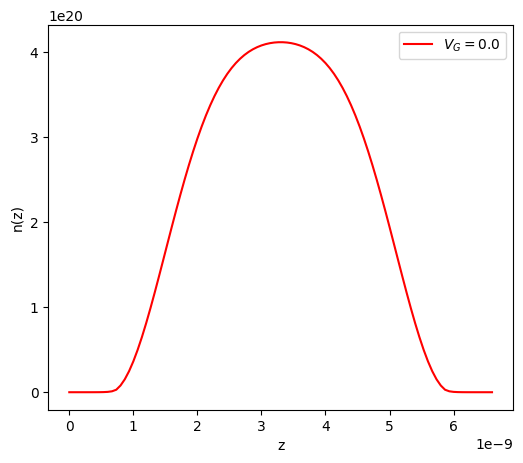

         Vg=0.0         
         Vg=0.1         
         Vg=0.2         
         Vg=0.30000000000000004         
         Vg=0.4         
         Vg=0.5         
         Vg=0.6000000000000001         
         Vg=0.7000000000000001         
         Vg=0.8         
         Vg=0.9         
         Vg=1.0         


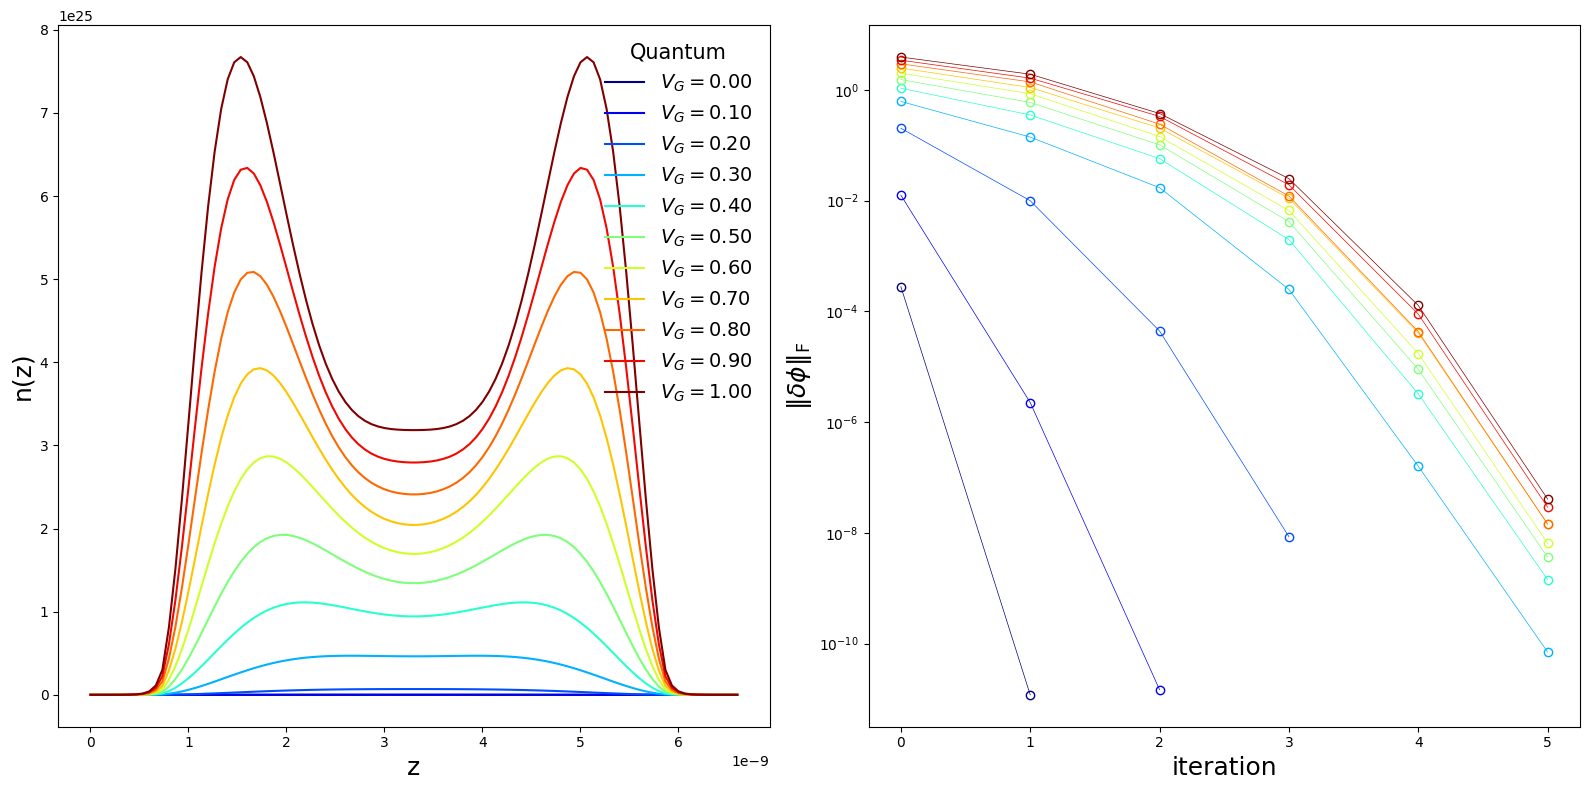

         Vg=0.0         
         Vg=0.02         
         Vg=0.04         
         Vg=0.06         
         Vg=0.08         
         Vg=0.1         
         Vg=0.12         
         Vg=0.14         
         Vg=0.16         
         Vg=0.18         
         Vg=0.2         
         Vg=0.22         
         Vg=0.24         


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_820\2602497237.py:256: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim(left=0)


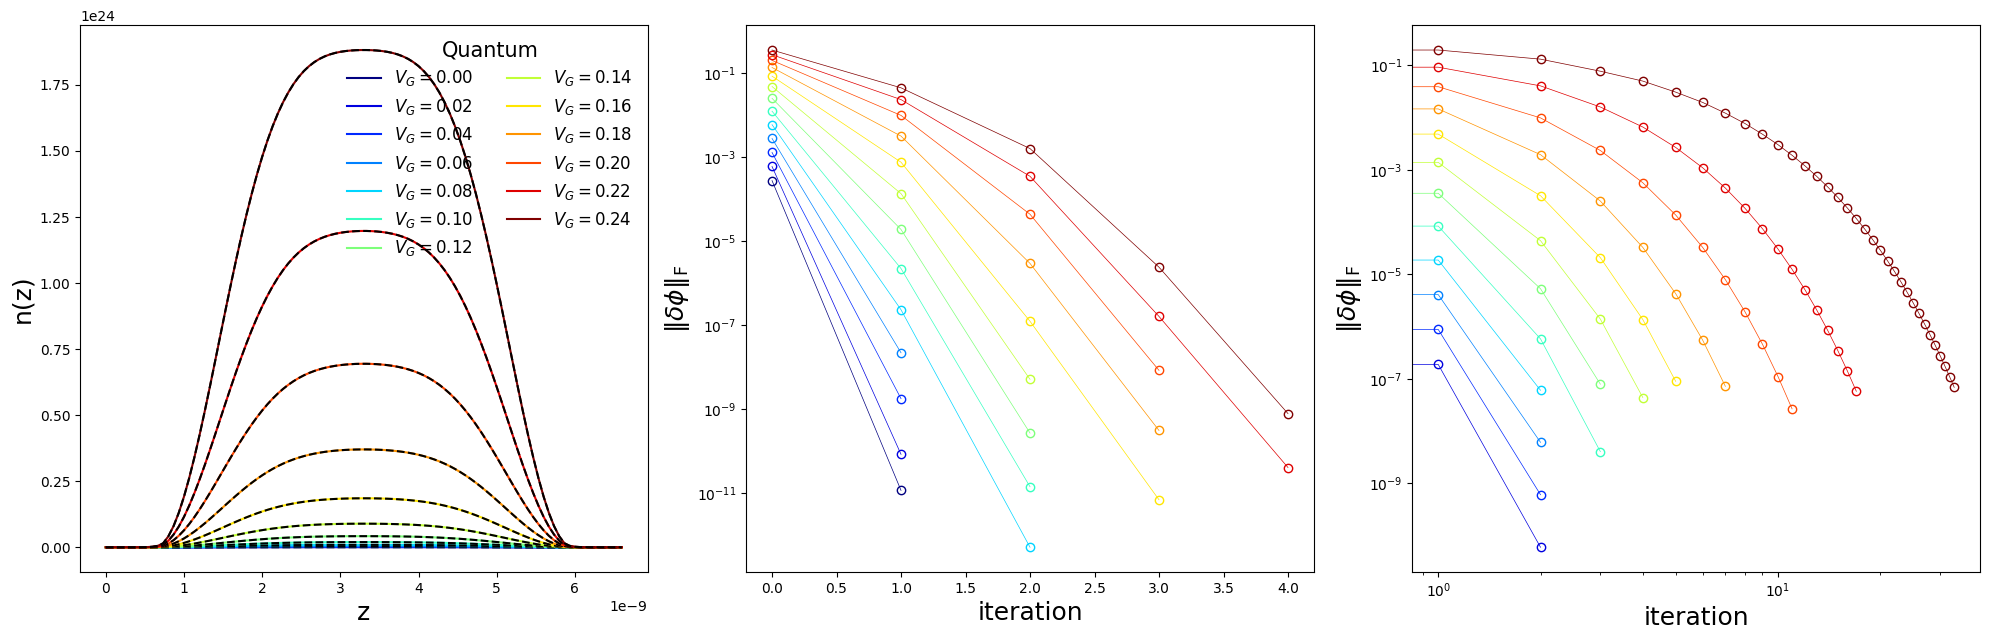

In [35]:
import numpy as np
from scipy.linalg import solve
from scipy.linalg import eigh
from scipy.integrate import simpson
import scipy.constants as const 
import matplotlib.pyplot as plt

N = 100
L = 6.6e-9
h = L/(N-1)
e1 = 3.9*const.epsilon_0
e2 = 11.7*const.epsilon_0
Nacc = 1e24
phi0 = 0.33374
T = 300.
ni = 2.86e25*np.exp(-const.e*0.56/(const.k*T))
M1 = int(N*8./66.)
M2 = int(N*58./66.)

mxx = 0.19*const.m_e
myy = 0.19*const.m_e
mzz = 0.91*const.m_e
Lx = 100e-9
Ly = 100e-9

#####################
#### Poisson eq. ####
#####################

def make_mat():
    H = np.zeros((N,N))

    np.fill_diagonal(H[:M1,:],-2.*e1/h)
    np.fill_diagonal(H[1:M1,:],e1/h)
    np.fill_diagonal(H[:M1,1:],e1/h)

    H[M1,M1] = (-e1-e2)/h; H[M1,M1+1] = e2/h; H[M1,M1-1] = e1/h

    np.fill_diagonal(H[M1+1:,M1+1:],-2.*e2/h)
    np.fill_diagonal(H[M1+1:,M1+2:],e2/h)
    np.fill_diagonal(H[M1+1:,M1:],e2/h)

    H[M2,M2] = (-e2-e1)/h; H[M2,M2+1] = e1/h; H[M2,M2-1] = e2/h

    np.fill_diagonal(H[M2+1:,M2+1:],-2.*e1/h)
    np.fill_diagonal(H[M2+1:,M2+2:],e1/h)
    np.fill_diagonal(H[M2+1:,M2:],e1/h)

    H[0,0] = 1.; H[N-1,N-1] = 1.
    H[0,1] = 0.; H[N-1,N-2] = 0.
    
    return H

def make_b(Vg,phi,n=np.zeros(N),feedback_on=False):
    b = np.zeros(N)

    b[M1+1:M2] = const.e*Nacc*h
    b[M1] = const.e*Nacc*h/2.
    b[M2] = const.e*Nacc*h/2.

    if feedback_on :
        b += const.e*n*h
    else :
        b[M1+1:M2] += 2.*const.e*ni*np.sinh(const.e*phi[M1+1:M2]/(const.k*T))*h
        b[M1] += const.e*ni*np.sinh(const.e*phi[M1]/(const.k*T))*h
        b[M2] += const.e*ni*np.sinh(const.e*phi[M2]/(const.k*T))*h

    b[0] = phi0+Vg; b[N-1] = phi0+Vg

    return b

def make_db(phi):
    db = np.zeros((N,N))

    np.fill_diagonal(db[M1+1:M2,M1+1:M2],2.*const.e*ni*np.cosh(const.e*phi[M1+1:M2]/(const.k*T))*const.e/(const.k*T)*h)
    db[M1,M1] = const.e*ni*np.cosh(const.e*phi[M1]/(const.k*T))*const.e/(const.k*T)*h
    db[M2,M2] = const.e*ni*np.cosh(const.e*phi[M2]/(const.k*T))*const.e/(const.k*T)*h

    return db

def Newton(dx_list,phi_,Vg):
    H = make_mat()

    dx = 1.; phi = phi_
    while dx > 1e-7:
        r = np.matmul(H,phi)-make_b(Vg,phi)
        J = H-make_db(phi)
        dphi = solve(J,-r)
        phi += dphi
        dx = np.linalg.norm(dphi)
        dx_list.append(dx)

    return phi

#########################
#### Schrodinger eq. ####
#########################

def make_mat_Ham():
    H = np.zeros((N-2,N-2))

    np.fill_diagonal(H,-2.)
    np.fill_diagonal(H[1:],1)
    np.fill_diagonal(H[:,1:],1)

    return H/h

def make_db_Ham(phi):
    phi_mat = np.full((N,N),phi)
    dphi_mat = np.diag(np.full(N,0.001))
    pdp_mat = phi_mat+dphi_mat

    n_mat = np.full((N,N),ele_density(phi))
    dn_mat = np.array([ ele_density(pdp_mat[i,:]) for i in range(N) ])

    db = const.e*h*(dn_mat-n_mat).T/np.diag(dphi_mat)

    return db

def FD_dist(E):
    return Lx*Ly/(2.*np.pi*const.hbar**2)*np.sqrt(mxx*myy)*const.k*T*np.log(1.+np.exp(-E/(const.k*T)))

def ele_density(phi):
    gap = np.full(N-2,4.5)
    gap[M1-1:M2] = 0.56

    mzz_list = np.full(N-2,0.58*const.m_e)
    mzz_list[M1-1:M2] = mzz

    Ham = make_mat_Ham()-2.*np.diag(mzz_list)*h/const.hbar**2*const.e*np.diag(gap-phi[1:N-1])
    E,V = eigh(-Ham*const.hbar**2/(2.*mzz*h))

    V = V*np.sqrt(1./h)
    v0 = np.zeros((1,N-2))
    V = np.concatenate((v0,V),axis=0)
    V = np.concatenate((V,v0),axis=0)

    #z = np.linspace(0,L,N)
    #print(simps(V[:,0]**2,z,h)) #print(simps(V[:,0]**2,x=z))

    n_list = np.sum(V**2*FD_dist(E),axis=1)

    return 2.*n_list/(Lx*Ly)

################
#### Solver ####
################

def self_consistency(dx_list,phi_,n_qn,Vg):
    dx = 1.
    while dx>1e-7:
        phi = solve(make_mat(),make_b(Vg,phi_,n_qn,True))
        n_qn = ele_density(phi)
        dphi = phi-phi_; phi_ = phi
        dx = np.linalg.norm(dphi); #print(dx)
        dx_list.append(dx)

    return n_qn

def Newton_Ham(dx_list,phi_,n_qn,Vg):
    H = make_mat()
    dx=1.; phi = phi_
    while dx>1e-7:
        r = np.matmul(H,phi)-make_b(Vg,phi,n_qn,True)
        J = H-make_db_Ham(phi)
        dphi = solve(J,-r)
        phi += dphi
        n_qn = ele_density(phi)
        dx = np.linalg.norm(dphi); #print(dx)
        dx_list.append(dx)

    return n_qn

phi_ = np.full(N,phi0)
z = np.linspace(0,L,N)

Vg = 0.0
dx_list=[]
phi = Newton(dx_list,phi_,Vg)
n_qn = ele_density(phi)

plt.figure(figsize=(6,5))

plt.xlabel('z')
plt.ylabel('n(z)')
plt.plot(z,n_qn,'r-',label='$V_G=$'+str(Vg))
plt.legend(loc='best')

plt.show()

fig,axs = plt.subplots(1,2,figsize=(16,8))

for Vg in np.linspace(0,1,11):
    print("         Vg="+str(Vg)+"         ")
    
    dx_list=[]
    phi = Newton(dx_list,phi_,Vg)
    n_qn = ele_density(phi)
    #n_cl = np.zeros(N); n_cl[M1:M2+1] =  ni*np.exp(const.e*phi[M1:M2+1]/(const.k*T)) 

    dx_list1 = []
    n_qn1 = Newton_Ham(dx_list1,phi,n_qn,Vg)

    axs[0].plot(z,n_qn1,c=plt.cm.jet(Vg),label='$V_G=$'+str(format(Vg,'1.2f')))
    #axs[1].plot(z,n_cl,c=plt.cm.coolwarm(Vg),label='$V_G=$'+str(format(Vg,'1.2f')))
    axs[1].plot(dx_list1,'.-',ms=12,lw=0.5,mfc='None',c=plt.cm.jet(Vg))

axs[0].set_xlabel('z',fontsize=18)
axs[0].set_ylabel('n(z)',fontsize=18)
legend = axs[0].legend(loc='upper right',ncol=1,fontsize=14,frameon=False)
legend.set_title('Quantum',prop={'size':15})
'''
axs[1].set_xlabel('z',fontsize=18)
axs[1].set_ylabel('n(z)',fontsize=18)
legend = axs[1].legend(loc='best',fontsize=18,frameon=False)
legend.set_title('Semi-classical',prop={'size':18})
'''
axs[1].set_xlabel('iteration',fontsize=18)
axs[1].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)
axs[1].set_yscale('log')

fig.tight_layout()
plt.show()

fig,axs = plt.subplots(1,3,figsize=(20,6.5))

for Vg in np.linspace(0,0.24,13):
    print("         Vg="+str(Vg)+"         ")
    
    dx_list=[]
    phi = Newton(dx_list,phi_,Vg)
    n_qn = ele_density(phi)

    dx_list1 = []; dx_list2 = []
    n_qn1 = Newton_Ham(dx_list1,phi,n_qn,Vg)
    n_qn2 = self_consistency(dx_list2,phi,n_qn,Vg)

    axs[0].plot(z,n_qn1,c=plt.cm.jet(Vg/0.24),label='$V_G=$'+str(format(Vg,'1.2f')))
    axs[0].plot(z,n_qn2,'k--')
    axs[1].plot(dx_list1,'.-',ms=12,lw=0.5,mfc='None',c=plt.cm.jet(Vg/0.24))
    axs[2].plot(dx_list2,'.-',ms=12,lw=0.5,mfc='None',c=plt.cm.jet(Vg/0.24))

axs[0].set_xlabel('z',fontsize=18)
axs[0].set_ylabel('n(z)',fontsize=18)
legend = axs[0].legend(loc='upper right',ncol=2,fontsize=12,frameon=False)
legend.set_title('Quantum',prop={'size':15})

axs[1].set_xlabel('iteration',fontsize=18)
axs[1].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)
axs[1].set_yscale('log')

axs[2].set_xlabel('iteration',fontsize=18)
axs[2].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim(left=0)

fig.tight_layout()
plt.show()

